# Modelling & Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


In [2]:
# reading in data 
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-post-nlp-190120.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [3]:
df.head()

,song,year,artist,genre,lyrics,acousticness,danceability,duration_ms,energy,instrumentalness,...,tempo,time_signature,valence,total_words,unique_words,unique_word_ratio,processed_quote,tokenised_quotes,objectivity_avg,polarity_avg
0,ego remix,2009,beyoncé,Pop,Oh baby how you doing You know Im gonna cut ri...,0.114,0.711,283520.0,0.439,0.000000,...,78.074,4.0,0.3260,433,144,0.332564,baby know m gon cut right chase women like thi...,"[baby, know, m, gon, cut, right, chase, women,...",0.805230,0.043886
1,honesty,2009,beyoncé,Pop,If you search For tenderness It isnt hard to f...,0.428,0.565,224387.0,0.442,0.000000,...,135.990,4.0,0.0717,169,110,0.650888,search tenderness hard find love need live loo...,"[search, tenderness, hard, find, love, need, l...",0.783309,-0.016317
2,all i could do was cry,2009,beyoncé,Pop,I heard Church bells ringing I heard A choir s...,0.358,0.372,190400.0,0.488,0.000706,...,185.262,3.0,0.5000,144,73,0.506944,heard Church bells ringing heard choir singing...,"[heard, Church, bells, ringing, heard, choir, ...",0.891815,-0.010986
3,once in a lifetime,2009,beyoncé,Pop,This is just another day that I would spend Wa...,0.171,0.313,239533.0,0.556,0.000032,...,79.209,3.0,0.4210,295,113,0.383051,day spend right Staring night wishin feel warm...,"[day, spend, right, Staring, night, wishin, fe...",0.841920,0.068590
4,save the hero,2009,beyoncé,Pop,I lay alone awake at night Sorrow fills my eye...,0.632,0.550,274573.0,0.472,0.000000,...,116.966,4.0,0.1610,241,107,0.443983,lay awake night fills eyes m strong cry disgui...,"[lay, awake, night, fills, eyes, m, strong, cr...",0.866951,0.004294


In [9]:
# dummifying target

genre_dict = {'Pop': 1, 'Hip-Hop': 2, 'Metal': 3, 'Country': 4, 'Jazz': 5, 
              'Electronic': 6, 'Rock': 7}

df.replace({'genre': genre_dict}, inplace=True)
df.genre = df.genre.astype('int')

## Choosing a Vectorizer

To create my model, I first needed to convert my documents' corpora into a numerical stucture using a vectorizer. 

TF-IDF stands for 'term frequency-inverse document frequency', this method of vectorizing assigns a weight to a word based on the number of times it occurs in a document inversely proportional to how many times it occurs in all documents in the dataset. This lowers the weight of words that occur often and increased the weight of words that are unique to the document, hence helping with classification problems and making it more useful than a count vectorizer. However, this method is not as memory efficient as using a hash vectorizer.

A hash vectorizer would be more memory efficient as it applies the hashing trick to encode tokens as numerical indexes. However, if I use this method I will not be able to retrieve feature names as planned through logistic regression. Therefore, I decided to go with TF-IDF vectorizer.

In [10]:
# vectorizing lyrics
lyrics = df.lyrics.values
tvec = TfidfVectorizer(token_pattern = '[a-z]+\w*', strip_accents = "ascii",  stop_words='english', 
                       norm='l2', max_features = 4000)
tvec.fit(lyrics)

# putting array into a dataframe so it can be attached to my original dataframe
tvec_df = pd.DataFrame(tvec.transform(lyrics).toarray(), columns=tvec.get_feature_names())

In [11]:
# dropping columns that I don't plan to use for modelling or that has high correlation with another feature

df.drop(['song', 'artist', 'lyrics', 'processed_quote', 'tokenised_quotes', 'unique_words'], axis=1, inplace=True)
df_dummies = pd.get_dummies(df)

In [12]:
# joining original dataframe with tvec features
df2 = pd.concat([df_dummies, tvec_df], axis=1)

In [13]:
df2.head()

,year,genre,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,...,yuh,yup,z,ze,zeit,zero,zone,zoo,zu,zum
0,2009,1,0.114,0.711,283520.0,0.439,0.000000,1.0,0.0573,-5.156,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2009,1,0.428,0.565,224387.0,0.442,0.000000,2.0,0.1090,-7.738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2009,1,0.358,0.372,190400.0,0.488,0.000706,9.0,0.1040,-9.471,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2009,1,0.171,0.313,239533.0,0.556,0.000032,1.0,0.1910,-10.929,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2009,1,0.632,0.550,274573.0,0.472,0.000000,10.0,0.0788,-9.829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
df2.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-dummified-190120.csv', index=False)

In [4]:
df = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/kaggle-dummified-190120.csv')

## Modelling

In [5]:
print('Baseline Accuracy:', df.genre.value_counts(normalize=True).max())

Baseline Accuracy: 0.25081832612622473


In [6]:
# separating target variable from the rest of the dataframe
X = df.copy()
y = X.pop('genre')

# standardising dataframe
scaler = StandardScaler()
Xstd = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# splitting dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state = 1)


### Logistic Regression

In [7]:
lr = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=200)
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print('Accuracy Score:', accuracy_score(y_test, lr_y_pred))
print('Training Score:', lr.score(X_train, y_train))
print('Test Score:', lr.score(X_test, y_test))

Accuracy Score: 0.3763319223471026
Training Score: 0.377895247180995
Test Score: 0.3763319223471026


### KNN

In [8]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_y_pred = knn.predict(X_test)

print('Accuracy Score:', accuracy_score(y_test, knn_y_pred))
print('Training Score:', knn.score(X_train, y_train))
print('Test Score:', knn.score(X_test, y_test))

Accuracy Score: 0.3237483579039556
Training Score: 0.5282213290377067
Test Score: 0.3237483579039556


### Random Forest

In [9]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)

print('Accuracy Score:', accuracy_score(y_test, rfc_y_pred))
print('Training Score:', rfc.score(X_train, y_train))
print('Test Score:', rfc.score(X_test, y_test))


Accuracy Score: 0.6058969493504598
Training Score: 0.9999687211648238
Test Score: 0.6058969493504598


### AdaBoost

In [10]:
base_estimator = DecisionTreeClassifier(max_depth=5)
adc = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=100, random_state=1)
adc.fit(X_train, y_train)
adc_y_pred = adc.predict(X_test)

print('Accuracy Score:', accuracy_score(y_test, adc_y_pred))
print('Training Score:', adc.score(X_train, y_train))
print('Test Score:', adc.score(X_test, y_test))


Accuracy Score: 0.5173697270471465
Training Score: 0.5784551383306485
Test Score: 0.5173697270471465


### Gradient Boosting

In [11]:
gbc = GradientBoostingClassifier(n_estimators=100,
                                   criterion='mse',
                                   loss='deviance',
                                   max_depth=3,
                                   random_state=1)
gbc.fit(X_train, y_train)
gbc_y_pred = gbc.predict(X_test)

print('Accuracy Score:', accuracy_score(y_test, gbc_y_pred))
print('Training Score:', gbc.score(X_train, y_train))
print('Test Score:', gbc.score(X_test, y_test))

Accuracy Score: 0.6027222303313385
Training Score: 0.6360394738899924
Test Score: 0.6027222303313385


# Evaluation

### Reviewing Coefficients of Logistic Regression

In [57]:
# putting coefficients from logistic regression into a dataframe and saving it into a csv
df_coef = pd.DataFrame(lr.coef_, columns=X_train.columns)
df_coef.to_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/lr-coefs-2-200120.csv', index=False)

In [14]:
# reading logistic regression coefficients csv back in
df_coef = pd.read_csv('/Users/sarinaamin/Desktop/capstone/genre-predictions-v2/lr-coefs-2-200120.csv')

In [15]:
# POP Positive Feature Importance
# there seems to be a fair amount of french stopwords effecting classification for pop songs
# lyrics seem to lean more towards love + relationships
# loudness + acousticness are the in the top 15

df_coef[:1].T.sort_values(by=0, ascending=False)[:20]

,0
loudness,2.376583e-06
love,4.519518e-08
que,4.093531e-08
oh,3.805704e-08
baby,2.887895e-08
la,2.562809e-08
polarity_avg,2.513561e-08
y,2.206005e-08
tu,2.108726e-08
te,2.039520e-08


In [16]:
# POP Negative Feature Importance
# pop music seems to be signifcantly negatively related to most other spotify features
# it is also defined as signficantly different to hip-hop and metal features 

df_coef[:1].T.sort_values(by=0, ascending=True)[:20]

,0
year,-5.039588e-04
total_words,-4.905140e-05
tempo,-3.174313e-05
key,-1.374786e-06
time_signature,-9.230056e-07
duration_ms,-4.298049e-07
unique_word_ratio,-3.114106e-07
energy,-2.764468e-07
objectivity_avg,-2.182836e-07
mode,-1.777190e-07


In [17]:
# HIP-HOP Positive Feature Importance
# total_words / speechiness were important features as expected, considering hip hop had a much wider distribution 
# of total words with a higher mean
# there seems to be more slang here than for other genres

df_coef[1:2].T.sort_values(by=1, ascending=False)[:20]

,1
total_words,1.157095e-02
loudness,5.370629e-05
danceability,5.960122e-06
speechiness,5.763849e-06
key,3.084674e-06
valence,2.823520e-06
nigga,1.928021e-06
im,1.602671e-06
niggas,1.578443e-06
shit,1.565561e-06


In [18]:
# HIP HOP Negative Feature Importance
# Hip hop is negatively related to softer features like love, heart, acousticness etc.

df_coef[1:2].T.sort_values(by=1, ascending=True)[:20]

,1
year,-1.778352e-03
tempo,-3.575575e-04
duration_ms,-7.864150e-06
mode,-5.583989e-06
acousticness,-4.284759e-06
instrumentalness,-3.402417e-06
unique_word_ratio,-1.558369e-06
love,-6.865853e-07
heart,-5.116868e-07
away,-4.593067e-07


In [19]:
# METAL Positive Feature Importance
# metal has almost no overlap with other genres, all features are in line with the definition of metal music
# metal songs can tend to be longer and may have more instrumental parts than with some other genres
# lyrics appear to be less repetitive despite distribution of total words being very similar to other genres

df_coef[2:3].T.sort_values(by=2, ascending=False)[:20]

,2
loudness,1.441241e-04
tempo,1.336835e-04
energy,1.493617e-05
instrumentalness,1.156302e-05
unique_word_ratio,6.864984e-06
duration_ms,5.360191e-06
death,1.273499e-06
blood,1.155935e-06
liveness,1.073049e-06
life,9.134053e-07


In [20]:
# METAL Negative Feature Importance
# surprisingly polarity score is negatively related, although metal was the only genre with a negative polarity score
df_coef[2:3].T.sort_values(by=2, ascending=True)[:20]

,2
total_words,-5.146203e-03
year,-9.471045e-04
acousticness,-1.402254e-05
valence,-1.224409e-05
danceability,-1.217243e-05
mode,-5.412223e-06
time_signature,-5.153760e-06
key,-4.252130e-06
love,-2.069285e-06
polarity_avg,-1.772273e-06


In [21]:
# Country Positive Feature Importance
# Mode/acousticness seemed to make a large difference for country music
# altogether the top features seem to be in line of my understanding of country music but some of these words
# have an overlap with other genres, hence why the spotify features may have had more importance

df_coef[3:4].T.sort_values(by=3, ascending=False)[:20]

,3
mode,1.277914e-05
acousticness,1.223439e-05
valence,1.836810e-06
danceability,1.136815e-06
love,1.099225e-06
old,9.500602e-07
little,7.613735e-07
home,7.505977e-07
heart,7.114434e-07
ive,6.771633e-07


In [22]:
# Country Negative Feature Importance
# country music seems to be strictly defined by audio features and moves away from slang

df_coef[3:4].T.sort_values(by=3, ascending=True)[:20]

,3
total_words,-2.661611e-03
year,-2.082935e-04
loudness,-9.755273e-05
tempo,-5.891870e-05
energy,-1.009387e-05
key,-6.829931e-06
duration_ms,-5.649415e-06
instrumentalness,-4.340156e-06
speechiness,-3.203836e-06
liveness,-1.568821e-06


In [23]:
# Jazz Positive Feature Importance
# the theme of love appears to be very important but is protrayed differently through these lyrical features than 
# what we saw in pop
df_coef[4:5].T.sort_values(by=4, ascending=False)[:20]

,4
acousticness,0.000685
love,0.000049
danceability,0.000047
valence,0.000046
polarity_avg,0.000032
baby,0.000017
blues,0.000015
dear,0.000015
blue,0.000015
sweet,0.000014


In [24]:
# Jazz Negative Feature Importance
# seems to be defined almost as the opposite of metal

df_coef[4:5].T.sort_values(by=4, ascending=True)[:20]

,4
tempo,-0.011362
loudness,-0.006642
total_words,-0.004297
energy,-0.000485
year,-0.000298
key,-0.000125
time_signature,-0.000083
unique_word_ratio,-0.000039
instrumentalness,-0.000030
mode,-0.000030


In [25]:
# Electronic Positive Feature Importance
# Electronic music tends to have simpler lyrics with less variance and is therefore strongly defined by its 
# audio features

df_coef[5:6].T.sort_values(by=5, ascending=False)[:20]

,5
tempo,0.003305
loudness,0.000379
key,0.000199
danceability,0.000113
instrumentalness,0.000085
time_signature,0.000064
energy,0.000057
valence,0.000040
wanna,0.000011
feel,0.000010


In [26]:
# Electronic Negative Feature Importance
# seems to be negatively related to a mixture of features important to other genres, mainly metal and hip-hop
df_coef[5:6].T.sort_values(by=5, ascending=True)[:20]

,5
total_words,-0.002203
year,-0.001709
mode,-0.000132
unique_word_ratio,-0.000101
acousticness,-0.000084
liveness,-0.000008
que,-0.000007
death,-0.000006
man,-0.000005
old,-0.000005


In [27]:
# Rock Positive Feature Importance
# rock lyrical features seem to contain more generic words, hence maybe why audio features are most important

df_coef[6:7].T.sort_values(by=6, ascending=False)[:20]

,6
tempo,0.004658
loudness,0.000243
mode,0.000044
valence,0.000043
energy,0.000035
time_signature,0.000028
liveness,0.000010
dont,0.000009
want,0.000007
gonna,0.000007


In [28]:
# Rock Negative Feature Importance
# Spotify features are more definitive for rock and hip-hop lyrics are negatively related

df_coef[6:7].T.sort_values(by=6, ascending=True)[:20]

,6
total_words,-0.003426
year,-0.000382
acousticness,-0.000073
instrumentalness,-0.000048
danceability,-0.000027
unique_word_ratio,-0.000025
speechiness,-0.000019
que,-0.000008
love,-0.000007
nigga,-0.000005


### Confusion Matrix

In [18]:
# 1:'Pop', 2:'Hip-Hop', 3:'Metal', 4:'Country', 5:'Jazz', 6:'Electronic', 7:'Rock'

# Hip-Hop has the highest precision, recall + f1 score
# Metal has the second highest success
# Pop + Rock have similar scores maybe because of the lyrical overlap between these genres
# Electronic has some of the lowest scores, which could be because there was not enough data on it and because
# lyrics tend to be simpler and repetitive meaning they could have more overlap with other genres (especially pop)

print('Classification Report:')
print()
print(classification_report(y_test, gbc_y_pred, digits=4))


Classification Report:

              precision    recall  f1-score   support

           1     0.5202    0.6190    0.5653      6695
           2     0.8496    0.7928    0.8202      3876
           3     0.7701    0.7253    0.7470      4397
           4     0.6025    0.4536    0.5176      2599
           5     0.5631    0.4068    0.4724      1492
           6     0.5018    0.1876    0.2731      1471
           7     0.5002    0.5890    0.5410      6874

    accuracy                         0.6027     27404
   macro avg     0.6153    0.5392    0.5624     27404
weighted avg     0.6110    0.6027    0.5991     27404




In [19]:
# There is a significant amount of overlap between Pop + Rock, showing the similarities between these genres lyrically
# Hip-hop, Metal, Country categories performed the best
# Other genres may have suffered more because there wasn't as much data on them
# Electronic music returned the worst results, often being confused for Pop and Rock

labels = [1, 2, 3, 4, 5, 6, 7]
cm = confusion_matrix(y_test, gbc_y_pred, labels)
df_cm = pd.DataFrame(cm, columns=['Pop', 'Hip-Hop', 'Metal', 'Country', 'Jazz', 'Electronic', 'Rock'],
                    index=['Pop', 'Hip-Hop', 'Metal', 'Country', 'Jazz', 'Electronic', 'Rock'])

print('Confusion Matrix:')
df_cm

Confusion Matrix:


,Pop,Hip-Hop,Metal,Country,Jazz,Electronic,Rock
Pop,4144,267,111,275,189,106,1603
Hip-Hop,453,3073,35,23,23,37,232
Metal,208,59,3189,16,10,31,884
Country,597,18,17,1179,113,10,665
Jazz,458,39,16,91,607,22,259
Electronic,579,78,85,29,21,276,403
Rock,1527,83,688,344,115,68,4049


### Accuracy Scores For All Models

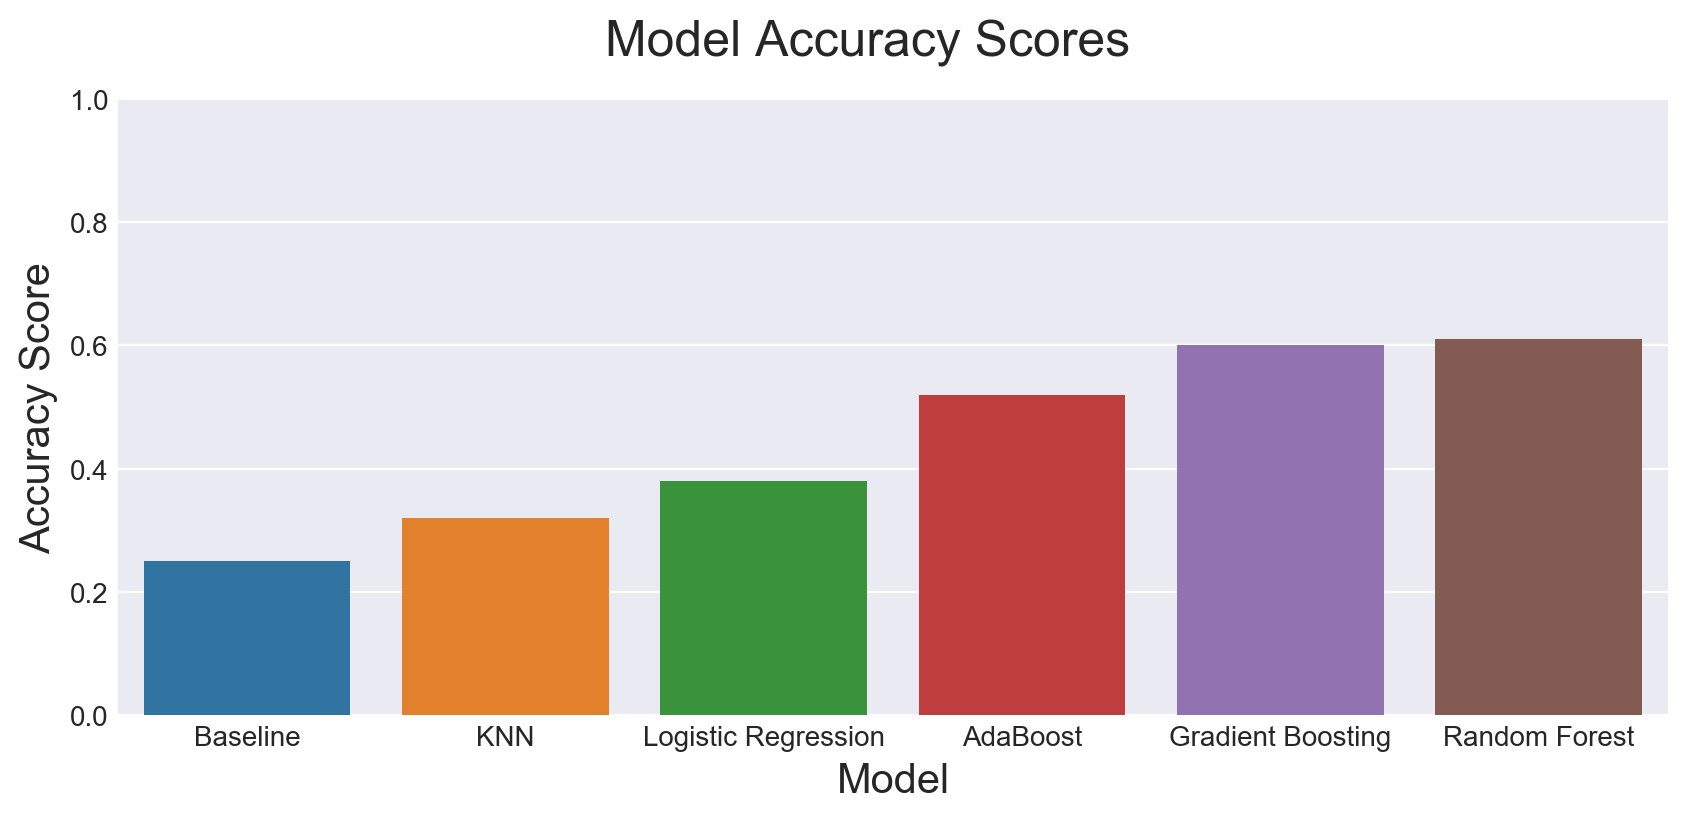

In [31]:
plt.style.use('seaborn-darkgrid')

x= ['Baseline', 'KNN', 'Logistic Regression', 'AdaBoost', 'Gradient Boosting', 'Random Forest']
y = [0.25, 0.32, 0.38, 0.52, 0.60, 0.61]

fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(x, y)
ax.set_ylim(0,1)
fig.suptitle('Model Accuracy Scores', fontsize=18)
plt.xlabel('Model', fontsize=15)
plt.ylabel('Accuracy Score', fontsize=15)
plt.show()

### Areas for Further Exploration

- Fine-Tuning Current Models / Using Different Types of Models e.g. Naive Bayes Classifiers (Multinomial, Bernoulli), Principal Component Analysis, neural networks
- Look further into what the NLKT package has to offer
- Find a solution for dealing with foreign languages
- Looking into word embedding using Word2Vec
- Attempt to directly analyse audio files myself
- Try to create my own genre classifications using unsupervised clustering
- Looking into Latent Dirichlet Allocation (LDS) for topic modelling
